In [24]:
#使用w*数据+b来进行先训练train数据集，然后在用在test数据集，w的维度为（step，输出的softmax的维度）
#pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
#预测的话，就直接调用w1和b1进行就行
from sklearn.datasets import load_iris
from sklearn import datasets
from pandas import DataFrame
import pandas as pd
import numpy as np
import tensorflow as tf
x_data = datasets.load_iris().data  # .data返回iris数据集所有输入特征
y_data = datasets.load_iris().target  # .target返回iris数据集所有标签
# print("x_data from datasets: \n", x_data)
# print("y_data from datasets: \n", y_data)
# x_data = DataFrame(x_data, columns=['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度']) # 为表格增加行索引（左侧）和列标签（上方）
# pd.set_option('display.unicode.east_asian_width', True)  # 设置列名对齐
# print("x_data add index: \n", x_data)
# x_data['类别'] = y_data  # 新加一列，列标签为‘类别’，数据为y_data
# print("x_data add a column: \n", x_data)


np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]
# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
#这里w的维度输入为4个维度，然后输出为3个维度，所有设置为[4,3],b设置为【3】
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和，计算数据所能划分的所有batch的损失值之和。这里120组数据，batch=32，那就只有4个step

#一般要不是大模型或者是自己编制的模型，都不采用这种前向传播，都是直接采用model就可以了
for epoch in range(epoch):  #数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  #batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            # 前向传播过程计算y
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy，这里表示的是真实值
            # 计算总loss
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])
        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(lr * grads[0])  # 参数w1自更新
        b1.assign_sub(lr * grads[1])  # 参数b自更新
    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {}".format(epoch, loss_all/4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备
    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")


Epoch 0, loss: 0.2821310982108116
Test_acc: 0.16666666666666666
--------------------------
Epoch 1, loss: 0.25459614023566246
Test_acc: 0.16666666666666666
--------------------------
Epoch 2, loss: 0.22570250555872917
Test_acc: 0.16666666666666666
--------------------------
Epoch 3, loss: 0.21028399467468262
Test_acc: 0.16666666666666666
--------------------------
Epoch 4, loss: 0.19942264631390572
Test_acc: 0.16666666666666666
--------------------------
Epoch 5, loss: 0.18873637914657593
Test_acc: 0.5
--------------------------
Epoch 6, loss: 0.17851300165057182
Test_acc: 0.5333333333333333
--------------------------
Epoch 7, loss: 0.16922875866293907
Test_acc: 0.5333333333333333
--------------------------
Epoch 8, loss: 0.16107673197984695
Test_acc: 0.5333333333333333
--------------------------
Epoch 9, loss: 0.15404684841632843
Test_acc: 0.5333333333333333
--------------------------
Epoch 10, loss: 0.14802725985646248
Test_acc: 0.5333333333333333
--------------------------
Epoch 11,

NameError: name 'plt' is not defined

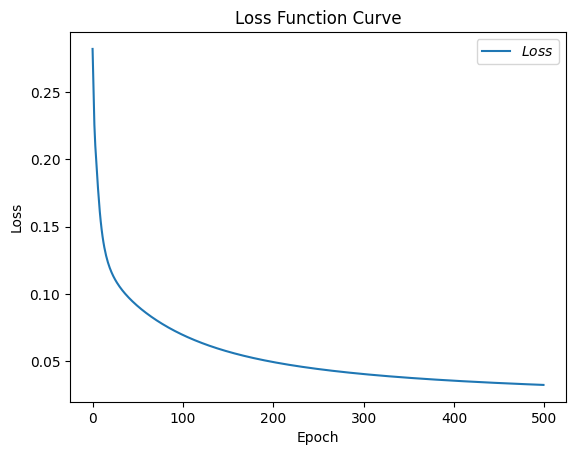

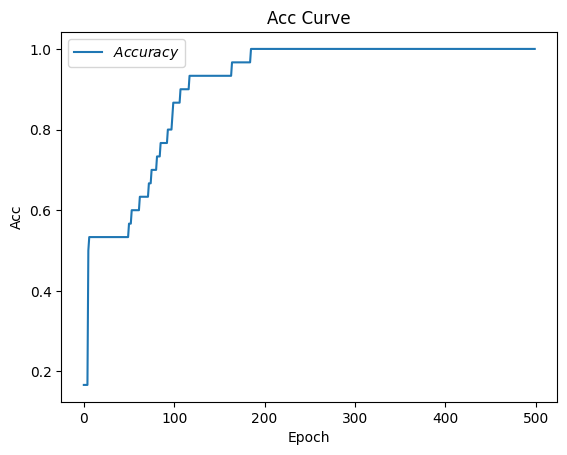

In [28]:
import matplotlib.pyplot as plt
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像
# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()
